# <a id='toc1_'></a>[Vector-born Disease Prediction](#toc0_)

**Author & Applicant**: Duarte Oliper

**Date**: January 2025

**Table of contents**<a id='toc0_'></a>    
- [Vector-born Disease Prediction](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Task 1 - Dataset Selection and Loading](#toc1_2_)    
    - [Dataset description & target definition](#toc1_2_1_)    
    - [Imports](#toc1_2_2_)    
    - [Data Loading](#toc1_2_3_)    
      - [Check for 'object' type variables](#toc1_2_3_1_)    
    - [Check for missing values](#toc1_2_4_)    
    - [Drop unique patient identifier (_uuid)](#toc1_2_5_)    
    - [Convert common string NaNs to None](#toc1_2_6_)    
    - [Remove samples with fractions from Age Column](#toc1_2_7_)    
    - [Clean temperature](#toc1_2_8_)    
    - [Clean Pulse Rate](#toc1_2_9_)    
    - [Other numerical variables - Fix ',' and '.'](#toc1_2_10_)    
    - [Replace boolean](#toc1_2_11_)    
    - [Handle Fractions in Arterial Pressure](#toc1_2_12_)    
    - [Convert all string variables to lower case](#toc1_2_13_)    
    - [Check for constant columns and remove them](#toc1_2_14_)    
    - [Fill remaining NaN](#toc1_2_15_)    
      - [Check for remaining missing values](#toc1_2_15_1_)    
  - [Task 2 - Feature Engineering](#toc1_3_)    
      - [Create variables for abscence/presence of related conditions](#toc1_3_1_1_)    
    - [Define target variable](#toc1_3_2_)    
    - [Check for constant columns and remove them](#toc1_3_3_)    
  - [Task 3 - Model Development](#toc1_4_)    
    - [Exploratory Data Analysis (EDA)](#toc1_4_1_)    
      - [Statistical Summary and Visualizations - ydata_profiling](#toc1_4_1_1_)    
      - [Target distribution](#toc1_4_1_2_)    
    - [Encode target labels](#toc1_4_2_)    
    - [Drop all features that can cause a target leak](#toc1_4_3_)    
    - [Encode remaining categorical variables](#toc1_4_4_)    
    - [Stratified train/val/test split](#toc1_4_5_)    
      - [Standardize Numerical Features](#toc1_4_5_1_)    
      - [Upsample minority classes](#toc1_4_5_2_)    
    - [Run Experiment - KNN, SVC and Ensemble](#toc1_4_6_)    
      - [Training and Evaluation](#toc1_4_6_1_)    
      - [Feature Importance (Permutation Importance)](#toc1_4_6_2_)    
      - [Save the final model](#toc1_4_6_3_)    
  - [Conclusion](#toc1_5_)    
    - [Next Steps - Deployment & Monitoring Considerations](#toc1_5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

In this notebook, you'll find tasks covering data selection, feature engineering, model development, and performance monitoring.

I spent 3-4 hours in Data Loading and Cleaning, 2 hours in Feature Engineering, and 1 hour in Modelling. Making some final adjustments and preparing the documentation for submission took me roughly 2 hours, so roughly 8 hours of total work time.

I would need to allocate some extra time to refactor and organize the code into scripts and pipelines, modularizing the code when needed, to facilitate reusage and deployment.

## <a id='toc1_2_'></a>[Task 1 - Dataset Selection and Loading](#toc0_)

Select and load a dataset appropriate for developing a supervised learning model. Ensure the dataset is tabular.

- Use `pandas` or equivalent tools to load the dataset into your notebook.
- Perform data cleaning, handling missing values appropriately.
- Document the data source, structure, and any preprocessing steps taken.

### <a id='toc1_2_1_'></a>[Dataset description & target definition](#toc0_)

**Dataset:** Tabular dataset for AI-based vector-borne disease prediction 

**Link:** https://data.mendeley.com/datasets/cf49v47z4c/1


This dataset gathers clinical information about patients diagnosed with malaria, dengue, yellow fever, and typhoid fever. Therefore, our **target** should correspond to the disease that the patient was diagnosed with, being:
1. Malaria
2. Dengue
3. Yellow Fever
4. Typhoid

The dataset includes 300 records. Among the consultations recorded, 150 are from DAFRA and 150 from DO. The data was preprocessed, and sensitive information such as name, surname, or place of birth was removed. The form contained 109 retained questions. 

The data includes two CSV files:
* "data.csv" - contains the data
* "description.xls" - contains the attribute descriptions
 
Some attributes are present in the description but not in the data, as they were removed due to lack of information.



### <a id='toc1_2_2_'></a>[Imports](#toc0_)

In [1]:
# Core
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
# from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from ydata_profiling import ProfileReport


### <a id='toc1_2_3_'></a>[Data Loading](#toc0_)

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
raw_dir = os.path.join(base_dir, "data", "raw")
data_path = os.path.join(raw_dir, "data.csv")

# load data
data = pd.read_csv(data_path, header=0, sep=';', decimal='.')

In [3]:
data.head(5)

,Centre de santé,Genre (Gender),Âge (Age),Poids (Weight),Circonference du bras (Mua circumference),"Haute température.(temperature, Hyperpyrexia)",Fièvre depuis 48 heures(Fever 48 hrs),Fièvre au cours des 7 derniers jours (Fever in the last 7 days),Type de fièvre (Type of Fever),Perte de poids (Loss of Weight),...,Maladies diagnostiquées/Paludisme (Malaria),Maladies diagnostiquées/Dengue,Maladies diagnostiquées/Chikunguya,Maladies diagnostiquées/Fièvre jaune (yellow fever),Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever),Maladies diagnostiquées/Zika,Maladies diagnostiquées/Autres maladies diagnostiqué (Others diseases),Maladies diagnostiquées/Option 8,Autres maladies présentées par le patient,_uuid
0,CMA de DO,Femme,18,55.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,df22d899-23a3-4c49-8059-6208c130f57d
1,CMA de DO,Homme,26,120.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4a7ef2f3-4ff0-4215-8cb5-20ba8c8d4355
2,CMA de DO,Homme,25,63.0,NaN,OUI,OUI,OUI,Récurrente,NON,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,104f6bc8-f39a-482b-b680-7ac1f8cccc86
3,CMA de DO,Homme,3,12.0,"13,5",OUI,OUI,NON,Récurrente,NON,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,26d7d04a-1a1c-4d4b-b64a-606f968e6d9c
4,CMA de DO,Homme,8,24.0,NaN,OUI,OUI,NON,Récurrente,NON,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,eb694f52-51ff-488d-9beb-2923a572a4cf


#### <a id='toc1_2_3_1_'></a>[Check for 'object' type variables](#toc0_)

In [4]:
data.select_dtypes(include=['object']).columns

Index(['Centre de santé', 'Genre (Gender)', 'Âge (Age)',
       'Circonference du bras (Mua circumference)',
       'Haute température.(temperature, Hyperpyrexia)',
       'Fièvre depuis 48 heures(Fever 48 hrs)',
       'Fièvre au cours des 7 derniers jours (Fever in the last 7 days)',
       'Type de fièvre (Type of Fever)', 'Perte de poids (Loss of Weight)',
       'Maux de tête (headache)', 'Nausée (Nausea)', 'Vomissement (Vomiting)',
       'Douleur articulaire (Joint pain)',
       'Gonflement des articulations (Joint Swelling)',
       'Douleur musculaire ( Muscle pain)', 'Douleur Thoracique (Chaist pain)',
       'Mal de dos / Douleur rachidienne ( Back pain / Rachiodynia)',
       'Troubles de la conscience (Consciousness trouble)',
       'Perte d'appétit ou Anorexie (Loss of appetite or Anorexia)',
       'Éruptions cutanées ou Exanthème (Skin rash or Exanthema)',
       'Éruption morbilliforme (Morbilliform rash)',
       'Saignement/ Manifestations hémorragiques (Bleeding)'

### <a id='toc1_2_4_'></a>[Check for missing values](#toc0_)

In [5]:
data.isnull().sum().sort_values(ascending=False).to_dict()

{'Circonference du bras (Mua circumference)': 275,
 'Temps de remplissage capillaire (médiane secs IQR). / Capillary refill time (median secs IQR)': 209,
 'Autres maladies présentées par le patient': 206,
 'Pression artérielle (moyenne mmHg ± SD). / Arterial blood pressure (mean mmHg ± SD)': 171,
 'Lymphocytes ': 153,
 'Hematocrite (Hematrocrit)': 105,
 'Poids (Weight)': 104,
 'Fréquence respiratoire (médiane IQR) / Respiratory rate (median breaths/min IQR)': 88,
 'Créatinine élevée / Elevated Creatinine': 82,
 'Neutrophiles / Neutrophils': 81,
 'Nombre de globules blancs (cellules/ML) / White blood cell count / WBC count (cells/ML)': 54,
 'Numération plaquettaire Platelet count': 50,
 'Température axillaire (médiane IQR) (°C) /Axillary temperature (median IQR) (°C)': 37,
 'Fréquence du pouls (battements/m in ± SD)./ Pulse rate (mean beats/min ± SD) - Shock ou Myocarditis': 37,
 'Goutte épaisse ': 30,
 'Test TDR': 29,
 'CRP>50 /CRP 10-50': 21,
 'ALAT / ASAT élevés. / Elevated ALAT / El

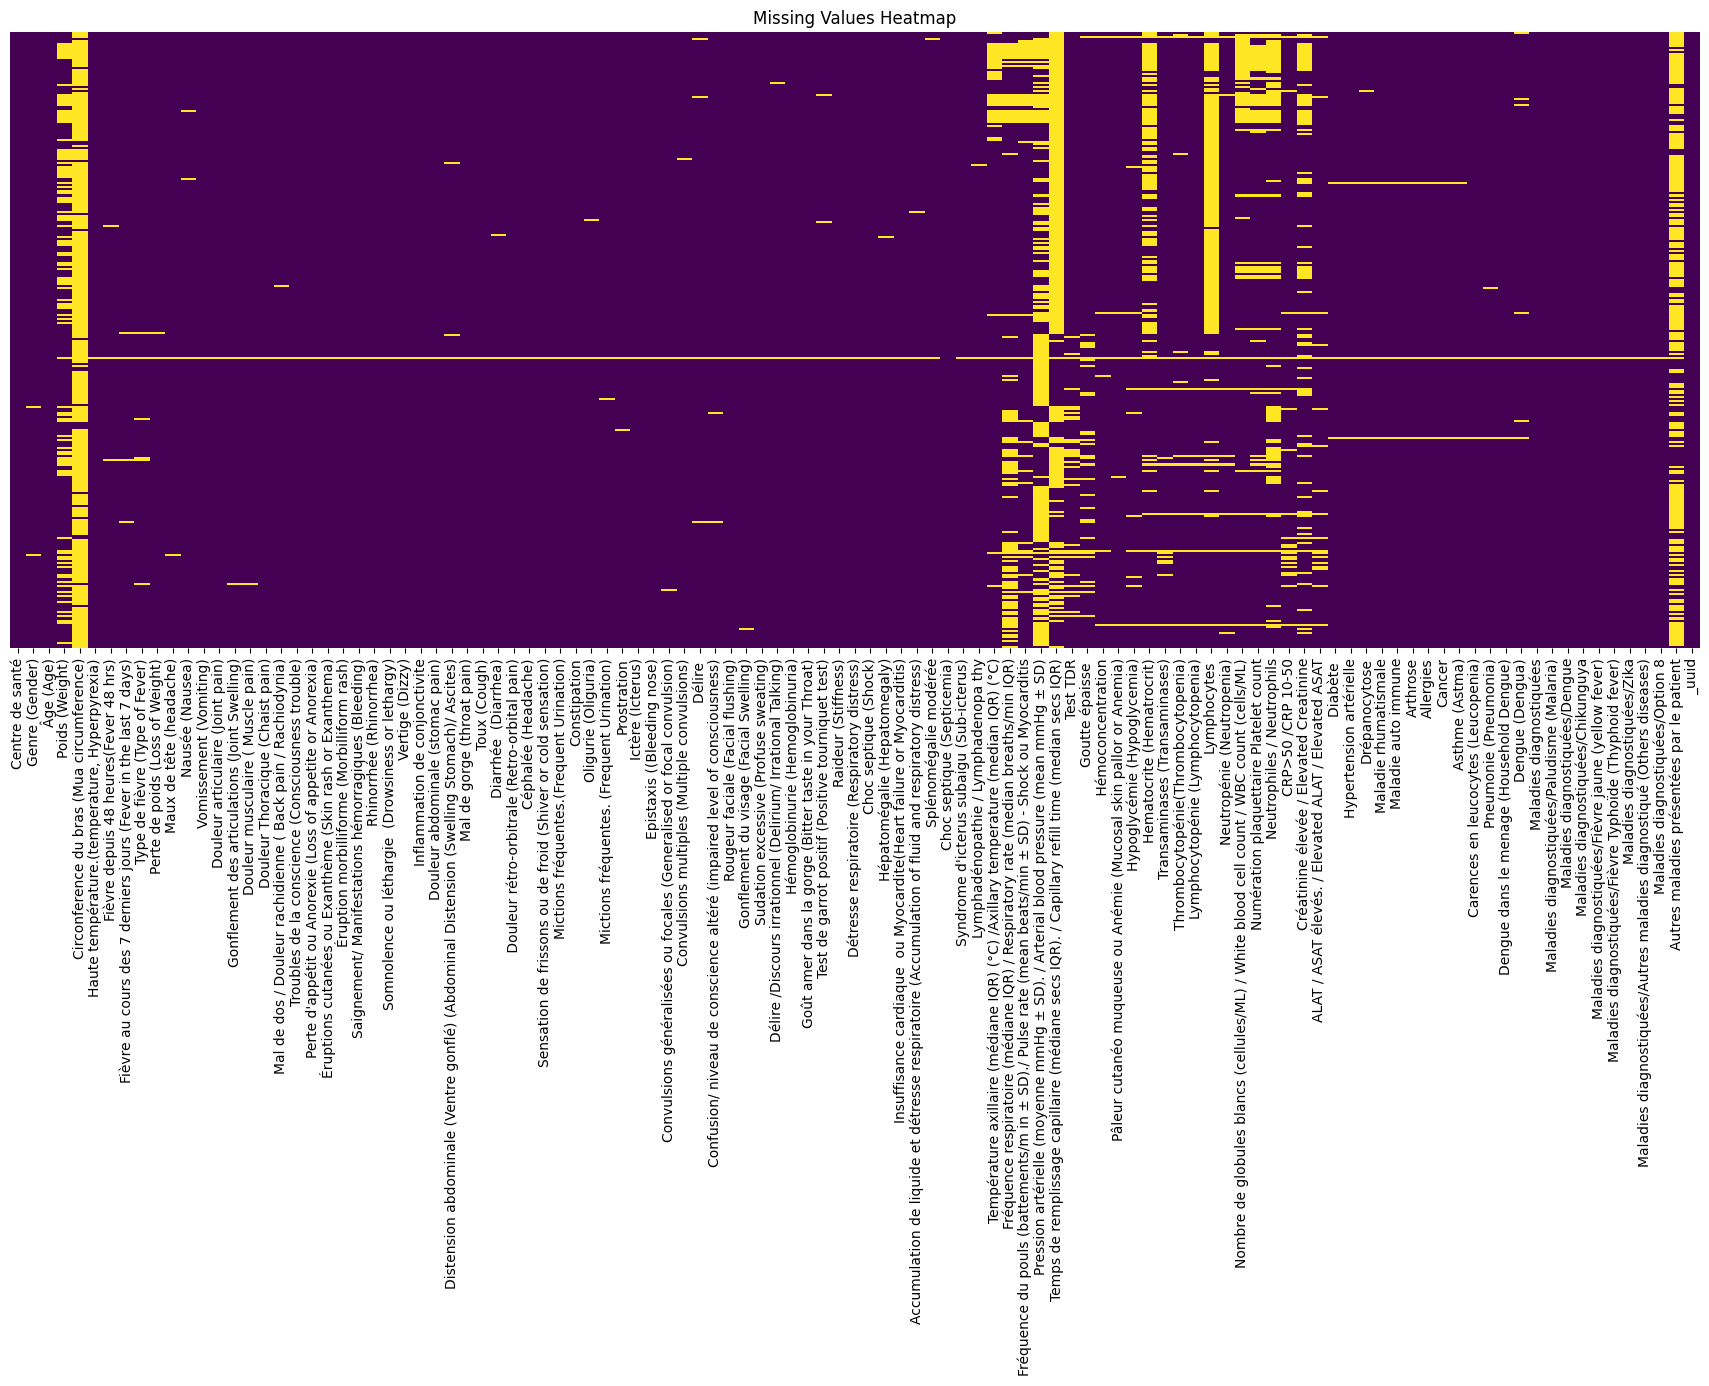

In [6]:
def plot_missing_values(data):
    # Adjust the figure size dynamically based on the number of columns
    plt.figure(figsize=(len(data.columns) * 0.2, 8))  # Increase the width for more columns
    
    # Create the heatmap with missing values
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis', xticklabels=True, yticklabels=False)
    
    # Set title and display the plot
    plt.title('Missing Values Heatmap')
    plt.show()

# Call the function with your dataset
plot_missing_values(data)

### <a id='toc1_2_5_'></a>[Drop unique patient identifier (_uuid)](#toc0_)

Not relevant for this analysis.

In [7]:
data = data.drop(columns=["_uuid"])

### <a id='toc1_2_6_'></a>[Convert common string NaNs to None](#toc0_)

In [8]:
# Define common string NaN values
nan_values = ["nan", "NaN", "N/A", "NULL", "None", ""]  # Add more if needed

# Replace common NaN strings with None
data = data.replace(nan_values, np.nan)

### <a id='toc1_2_7_'></a>[Remove samples with fractions from Age Column](#toc0_)

In [9]:
data["Âge (Age)"].unique()

array(['18', '26', '25', '3', '8', '6', '2', '2.8', '20', '14', '57',
       '28', '24', '29', '68', '4.4', '19', '80', '7', '15', '34', '85',
       '7/12', '55', '31', '46', '4', '12', '1.6', '61', '22', '60',
       '3,83', '10', '75', '38', '39', '56', '41', '16', '35', '15/12',
       '45', '50', '67', '40', '1.3', '44', '78', '36', '2.6', '42',
       '2.1', '3.6', '30', '5', '70', '11', '23', '0.11', '71', '32',
       '17', '05', '9', '49', '13', '58', '3.2', '0.9', '1', '0.10',
       '1.2', '4.11', '2.3', '0.7', '1.8', '0.1', '2.10', '1.1', '1.9',
       '3.4', '2.4', '74', '64', '37', '5.6', '47', '63', '6.4', '82',
       '77', '69', '76', '4.10', '2.7', '4.7', '1.10', '2.2', '1.5',
       '1.7', '2.5', '62', '54', '84', '65', '52', '21', '4.5'],
      dtype=object)

In [10]:
# Filter out rows where the "Âge (Age)" column contains fractions
data = data[~data["Âge (Age)"].str.contains("/", na=False)]

### <a id='toc1_2_8_'></a>[Clean temperature](#toc0_)

In [11]:
data["Température axillaire (médiane IQR) (°C) /Axillary temperature (median IQR) (°C)"].unique()

array([nan, 'T3501', '3904', '39', '40', '39.8', '390', '3909', '39.6',
       '37.9', '3901', '38.9', '38.2', '40.1', '38', '39.2', '38.7',
       '38.1', '38.6', '37', '37.8', '34.1', '36', '39.9', '40.6', '38.8',
       '36.5', '36.4', '39.7', '39.4', '36,4', '38,8', '39,1', '36,8',
       '37,2', '38,9', '39,6', '38,7', '39.1', '38.4', '40.5', '37.2',
       '39.3', '35.7', '37.5', '36.6', '36.3', '19.76', '36.8', '35.9',
       '40.9', '367', '36.2', '35.6', '37.1', '36.7', '37.4', '37.6',
       '34.6', '37.7', '36.9', '38.5', '36.1', '40.7', '38,6', '35.4',
       '36,6', '37,8', '38.3', '37,3', '37,5', '36,3', '39,5', '37,9',
       '37.3', '34,9', '38,1'], dtype=object)

In [12]:
# Replace ',' with '.' and remove non-numeric characters
def clean_temp(value):
    if pd.isna(value):
        return None  # Keep NaN as is
    value = str(value).replace(',', '.')  # Convert comma to dot
    value = ''.join(filter(str.isdigit, value))  # Remove non-numeric characters

    if value:  # If the cleaned string is not empty
        num = float(value) / 10 if len(value) > 2 else float(value)  # Adjust scaling if needed
        return num if 30 <= num <= 45 else None  # Keep only reasonable temperatures

    return None

# Apply the cleaning function and drop original column
data["Cleaned_Temperature"] = data["Température axillaire (médiane IQR) (°C) /Axillary temperature (median IQR) (°C)"].apply(clean_temp)
data = data.drop(columns=["Température axillaire (médiane IQR) (°C) /Axillary temperature (median IQR) (°C)"])


In [13]:
data["Cleaned_Temperature"].unique()

array([ nan, 39. , 40. , 39.8, 39.6, 37.9, 38.9, 38.2, 40.1, 38. , 39.2,
       38.7, 38.1, 38.6, 37. , 37.8, 34.1, 36. , 39.9, 40.6, 38.8, 36.5,
       36.4, 39.7, 39.4, 39.1, 36.8, 37.2, 38.4, 40.5, 39.3, 35.7, 37.5,
       36.6, 36.3, 35.9, 40.9, 36.7, 36.2, 35.6, 37.1, 37.4, 37.6, 34.6,
       37.7, 36.9, 38.5, 36.1, 40.7, 35.4, 38.3, 37.3, 39.5, 34.9])

In [14]:
data.shape

(298, 108)

In [15]:
# count nan
data["Cleaned_Temperature"].isnull().sum()

np.int64(42)

### <a id='toc1_2_9_'></a>[Clean Pulse Rate](#toc0_)

In [16]:
data["Fréquence du pouls (battements/m in ± SD)./ Pulse rate (mean beats/min ± SD) - Shock ou Myocarditis"].unique()

array(['131', '38', '100', '88', nan, '130', '62', '92', '107', '98',
       '101', '68', '114', '86', '72', '41', '102', '118', '112/58',
       '108', '165/113', '110', '127', '26', '104', '97', '119', '111',
       '124', '105', '125', '112', '89', '152', '96', '64', '113', '144',
       '78', '115', '140', '109', '82', '80', '126', '151', '123', '154',
       '95', '90', '76', '84', '71', '106', '147', '135', '145', '174',
       '155', '136', '156', '128', '172', '165', '166', '150', '138',
       '146', '124000', '120', '143', '103', '87', '132', '164', '160',
       '195', '149', '66', '134', '117', '129', '63', '178', '204', '179',
       '169', '180', '139', '91', '59', '116', '121', '167', '65', '190',
       '94', '121/67', '93', '144/82', '122', '187', '133'], dtype=object)

In [17]:
# Cleaning function
def clean_pulse_rate(value):
    if pd.isna(value):
        return np.nan  # Keep NaN values

    value = str(value).strip()  # Ensure it's a string and remove extra spaces
    
    # If there's a '/', take only the first part (before the slash)
    if '/' in value:
        value = value.split('/')[0]  
    
    try:
        num = float(value)
        # Remove extreme outliers
        if num < 20 or num > 300:  # Assuming normal pulse rates range
            return np.nan
        return num
    except ValueError:
        return np.nan  # Return NaN for non-numeric values

# Apply cleaning
data["Cleaned_Pulse_Rate"] = data["Fréquence du pouls (battements/m in ± SD)./ Pulse rate (mean beats/min ± SD) - Shock ou Myocarditis"].apply(clean_pulse_rate)
# Drop original column
data = data.drop(columns="Fréquence du pouls (battements/m in ± SD)./ Pulse rate (mean beats/min ± SD) - Shock ou Myocarditis")

In [18]:
# Display cleaned values
print(data["Cleaned_Pulse_Rate"].unique())

[131.  38. 100.  88.  nan 130.  62.  92. 107.  98. 101.  68. 114.  86.
  72.  41. 102. 118. 112. 108. 165. 110. 127.  26. 104.  97. 119. 111.
 124. 105. 125.  89. 152.  96.  64. 113. 144.  78. 115. 140. 109.  82.
  80. 126. 151. 123. 154.  95.  90.  76.  84.  71. 106. 147. 135. 145.
 174. 155. 136. 156. 128. 172. 166. 150. 138. 146. 120. 143. 103.  87.
 132. 164. 160. 195. 149.  66. 134. 117. 129.  63. 178. 204. 179. 169.
 180. 139.  91.  59. 116. 121. 167.  65. 190.  94.  93. 122. 187. 133.]


### <a id='toc1_2_10_'></a>[Other numerical variables - Fix ',' and '.'](#toc0_)

In [19]:
data["Circonference du bras (Mua circumference)"].unique()

array([nan, '13,5', '13', '14', '13.55', '13.5', '13,55', '150', '155',
       '120', '132', '141', '140', '160', '130', '127', '116'],
      dtype=object)

In [20]:
data["Âge (Age)"].unique()

array(['18', '26', '25', '3', '8', '6', '2', '2.8', '20', '14', '57',
       '28', '24', '29', '68', '4.4', '19', '80', '7', '15', '34', '85',
       '55', '31', '46', '4', '12', '1.6', '61', '22', '60', '3,83', '10',
       '75', '38', '39', '56', '41', '16', '35', '45', '50', '67', '40',
       '1.3', '44', '78', '36', '2.6', '42', '2.1', '3.6', '30', '5',
       '70', '11', '23', '0.11', '71', '32', '17', '05', '9', '49', '13',
       '58', '3.2', '0.9', '1', '0.10', '1.2', '4.11', '2.3', '0.7',
       '1.8', '0.1', '2.10', '1.1', '1.9', '3.4', '2.4', '74', '64', '37',
       '5.6', '47', '63', '6.4', '82', '77', '69', '76', '4.10', '2.7',
       '4.7', '1.10', '2.2', '1.5', '1.7', '2.5', '62', '54', '84', '65',
       '52', '21', '4.5'], dtype=object)

In this case, '3,83' should be '3.83' instead. Commas and points are mixed in.

In [21]:
# Convert all possible numeric columns safely
def convert_numeric(col):
    try:
        return pd.to_numeric(col.astype(str).str.replace(',', '.', regex=True).str.strip().astype(float))
    except Exception:
        return col  # Return original if conversion fails

data = data.apply(convert_numeric)

In [22]:
data["Circonference du bras (Mua circumference)"].unique()

array([   nan,  13.5 ,  13.  ,  14.  ,  13.55, 150.  , 155.  , 120.  ,
       132.  , 141.  , 140.  , 160.  , 130.  , 127.  , 116.  ])

### <a id='toc1_2_11_'></a>[Replace boolean](#toc0_)

* Replace "OUI" or "Positif" with True
* Replace "NON", "Négatif" or None with False

Note: To handle None values, there could also be a "not tested"category, turning this variables into categorical. However, since the most probable cause is omission for not needing to inquire the patient, or absence of symptom/condition, I chose to advance with this simpler approach.

In [23]:
# Function to check if a column contains only "OUI", "NON", "Positif", "Négatif", or None
def is_valid_boolean_column(col):
    valid_values = {"OUI", "NON", "Positif", "Négatif ", None}
    return set(col.dropna().unique()).issubset(valid_values)

# Loop through each column and apply the transformation only if it's valid
for col in data.columns:
    if is_valid_boolean_column(data[col]):
        with pd.option_context("future.no_silent_downcasting", True):
            # Replace "OUI" with True, "NON" with False, "Positif" with True, "Négatif" with False, and NaN with False
            data[col] = data[col].replace({'OUI': True, 'NON': False, 'Positif': True, 'Négatif ': False, None: False}).astype(bool)

In [24]:
data.dtypes.value_counts()

bool       81
float64    21
object      6
Name: count, dtype: int64

### <a id='toc1_2_12_'></a>[Handle Fractions in Arterial Pressure](#toc0_)

In [25]:
data['Pression artérielle (moyenne mmHg ± SD). / Arterial blood pressure (mean mmHg ± SD)'].unique()

array(['10976', '77/61', '104|58', nan, '120/90', '120/80', '130/84',
       '113/66', '132/73', '100|62', '119/82', '56/44', '100/46',
       '112/68', '155/89', '175/132', '98', '136/78', '141/89', '115',
       '140/103', '113/63', '13/8', '131/85', '111/61', '174/116',
       '144/78', '105/73', '13/6', '100/65', '100/81', '113/68', '105/70',
       '165/95', '9/7', '87/76', '14/8', '136/110', '127/82', '164/79',
       '120/81', '142/87', '107/73', '163/88', '107/62', '120/82',
       '160/90', '18/13', '11/8', '12/6', '148/92', '103/74', '108/69',
       '162/92', '202/101', '106/73', '130/85', '95/61', '141/67',
       '124/94', '11/7', '111/69', '125/94', '10/6', '112/52', '141/73',
       '129/63', '140/110', '10/8', '208/123', '106/64', '130/82',
       '123/66', '93/68', '103/57', '111/82', '137/84', '136/60',
       '107/59', '127/80', '116/61', '100/60', '145/77', '101/59',
       '70/40', '125/56', '145/70', '137/63', '149/98', '83/54', '102/50',
       '108/57', '65/49',

It is expected a fraction in this reading at all times. It should be a numerator and a denominator. However, there are a few mistakes that need to be deleted from the dataset. Here are the changes:

| Original | Numerator | Denominator |
|----------|-----------|-------------|
| 10976    | None      | None        |
| 77/61    | 77        | 61          |
| 104|58   | None      | None        |
| None     | None      | None        |
| 120/90   | 120       | 90          |

This algorithm processes the entire column by:
1. Identifying valid fraction format (i.e., `systolic/diastolic`).
2. Returning the systolic and diastolic values for valid formats, and `None` for invalid or non-fraction cases.

In [26]:
# Function to process and split blood pressure values into numerator and denominator
def process_blood_pressure(value):
    if isinstance(value, str) and '/' in value:  # Check if it's a fraction
        numerator, denominator = value.split('/')
        if numerator.isdigit() and denominator.isdigit():
            return [numerator, denominator]  # Valid fraction, split into systolic/diastolic
    return [np.nan, np.nan]  # Invalid fraction or non-fraction case

# Apply the function to the specific column 'Pression artérielle (moyenne mmHg ± SD). / Arterial blood pressure (mean mmHg ± SD)'
split_data = data['Pression artérielle (moyenne mmHg ± SD). / Arterial blood pressure (mean mmHg ± SD)'].apply(process_blood_pressure)

# Extract the numerator and denominator columns
numerator, denominator = zip(*split_data)

# Add the Numerator and Denominator columns to the original DataFrame
data["Pression artérielle (moyenne mmHg ± SD)"] = numerator
data["Arterial blood pressure (mean mmHg ± SD)"] = denominator

# Convert to numeric
data = data.apply(convert_numeric)

# Drop the original column if you don't need it anymore
data = data.drop(columns=['Pression artérielle (moyenne mmHg ± SD). / Arterial blood pressure (mean mmHg ± SD)'])

In [27]:
print(data["Pression artérielle (moyenne mmHg ± SD)"].isnull().sum())
print(data["Arterial blood pressure (mean mmHg ± SD)"].isnull().sum())

print(data["Pression artérielle (moyenne mmHg ± SD)"].unique())
print(data["Arterial blood pressure (mean mmHg ± SD)"].unique())

176
176
[ nan  77. 120. 130. 113. 132. 119.  56. 100. 112. 155. 175. 136. 141.
 140.  13. 131. 111. 174. 144. 105. 165.   9.  87.  14. 127. 164. 142.
 107. 163. 160.  18.  11.  12. 148. 103. 108. 162. 202. 106.  95. 124.
 125.  10. 129. 208. 123.  93. 137. 116. 145. 101.  70. 149.  83. 102.
  65.  90. 201.  99.  97.  92. 118. 104.  80. 172. 110. 117.]
[ nan  61.  90.  80.  84.  66.  73.  82.  44.  46.  68.  89. 132.  78.
 103.  63.   8.  85. 116.   6.  65.  81.  70.  95.   7.  76. 110.  79.
  87.  88.  62.  13.  92.  74.  69. 101.  67.  94.  52. 123.  64.  57.
  60.  59.  77.  40.  56.  98.  54.  50.  49.  91.  51.  53.  72. 108.
  75.  47.  71.]


### <a id='toc1_2_13_'></a>[Convert all string variables to lower case](#toc0_)

In [28]:
data.select_dtypes(include=['object']).columns

Index(['Centre de santé', 'Genre (Gender)', 'Type de fièvre (Type of Fever)',
       'Maladies diagnostiquées', 'Autres maladies présentées par le patient'],
      dtype='object')

In [29]:
# convert string variables to lower case
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

### <a id='toc1_2_14_'></a>[Check for constant columns and remove them](#toc0_)

In [30]:
data.shape

(298, 109)

In [31]:
# find constant columns and remove them
def remove_constant_columns(data):
    constant_columns = data.columns[data.nunique() == 1]
    data = data.drop(columns=constant_columns)
    return data

Note that none of the columns regarding the target columns were caught

In [32]:
# remove constant columns
data = remove_constant_columns(data)

In [33]:
data.shape

(298, 98)

### <a id='toc1_2_15_'></a>[Fill remaining NaN](#toc0_)

* in numerical variables with mean
* in string variables with empty string, ''

In [34]:
for i in data.columns[data.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    # Replace NaNs with the mean of each numerical column
    data.fillna(data.mean(numeric_only=True), inplace=True)
    # Replace NaNs in categorical columns with empty string
    data.fillna("", inplace=True)

#### <a id='toc1_2_15_1_'></a>[Check for remaining missing values](#toc0_)

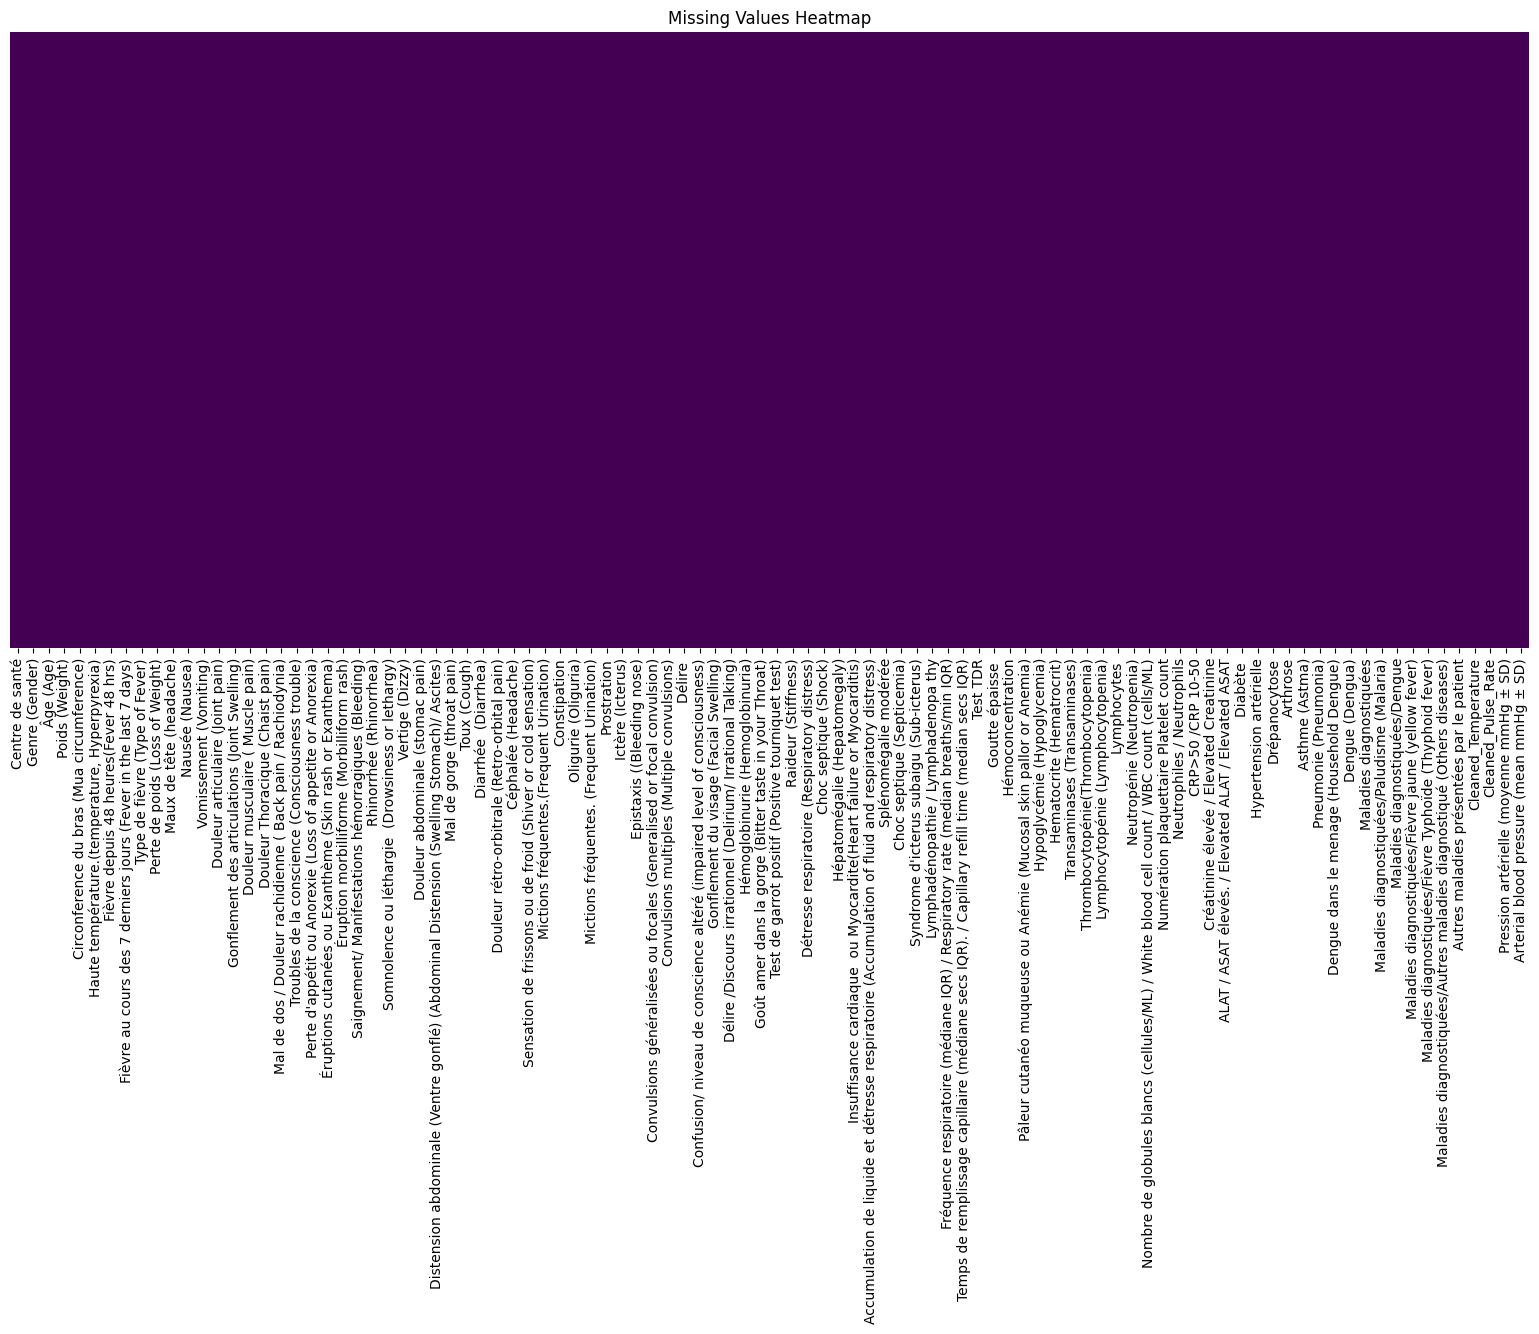

In [35]:
plot_missing_values(data)

## <a id='toc1_3_'></a>[Task 2 - Feature Engineering](#toc0_)

Develop a comprehensive feature engineering pipeline with an emphasis on:

- **Reproducibility** – Ensure that transformations are consistently applied to new data.
- **Scalability** – Design pipelines that efficiently handle large datasets.

Incorporate feature selection, transformation, encoding, and scaling, providing clear explanations on how each step improves model performance.

#### <a id='toc1_3_1_1_'></a>[Create variables for abscence/presence of related conditions](#toc0_)

**Medical Context**
Certain health conditions can make individuals more vulnerable to severe complications from diseases like Malaria, Dengue, Yellow Fever, and Typhoid. I am looking for a few specific conditions that are particularly important for understanding this risk.


**Key Conditions to Check For:**
* Diabetes (e.g., "Diabete"): Diabetes weakens the immune system, making it harder for the body to fight infections.
* Asthma (e.g., "Bronchite", "Bronchopneumopathie"): Asthma affects the lungs and can make respiratory infections, like Pneumonia, worse.
* Pneumonia (e.g., "Pneumonie"): Pneumonia weakens the lungs and increases the risk of complications from infections.
* Cardiovascular Diseases (e.g., "Cardiopathie", "HTA" for hypertension): Heart disease and high blood pressure can make it harder for the body to manage stress from infections.
* Kidney Disease (e.g., "Insuffisance Rénale"): Kidney problems affect how the body processes waste and can worsen the effects of infections.
* Sickle Cell Disease (e.g., "Drépanocytose"): This blood disorder can make the body more vulnerable to diseases like Malaria.
* Liver Diseases (e.g., "Hepatite"): Liver diseases weaken the body’s ability to detoxify, making infections like Yellow Fever more dangerous.
* Weakened Immune System (e.g., conditions like cancer): People with a weak immune system are at higher risk of severe infections.

In [36]:
data['Autres maladies présentées par le patient'].value_counts().to_dict()

{'': 205,
 'pneumonie': 4,
 'sepsis': 3,
 'ugd': 2,
 'pneumonie sévère': 2,
 'cardiopathie': 2,
 'diabete + hta': 2,
 'lombarthrose': 2,
 'geaf': 2,
 'sepsis,  anémie': 2,
 'mcs': 2,
 'pneumopathie': 2,
 'hta': 2,
 'gastro entente aigue febrile': 1,
 'bronchite aigue': 1,
 'ulcere gastro duostanole (ugd)': 1,
 'bronchopneumopathie (bpp)': 1,
 'bpp': 1,
 'pneumonie, ugd': 1,
 'syndromes infectieux': 1,
 'sepsio': 1,
 'épilepsie': 1,
 'drépanocytose (ss)': 1,
 'cardiopathie décompensée': 1,
 'gea': 1,
 'drepanocytaire': 1,
 'bpp a  bk  tuberculose puitomiale': 1,
 'infection  bacterienne': 1,
 'sepsis, meningo  -  encephalité': 1,
 'angine de gorge': 1,
 'pneumonie  sévère': 1,
 'laryngite  aigue': 1,
 'mcs, pneumonie': 1,
 'mas,  geaf': 1,
 'broncho pneumopathie  a': 1,
 'anemie': 1,
 'insuffisance rénale': 1,
 'rougeole,  varicelle,  geaf': 1,
 'mas(déshydratation)': 1,
 'bronchite': 1,
 'meningite': 1,
 'broncopneumopathie (bpp)': 1,
 'gastro enterite  aigue  febril': 1,
 'infection d

We’ll create a column for each of these conditions in the dataset. Each column will have a “True” or “False” value, depending on whether the patient has that condition. This will help identify individuals who might be at higher risk of complications from Malaria, Dengue, Yellow Fever, or Typhoid.

**Steps:**
* We check if the patient’s health record mentions any of the key conditions (like Diabetes, Asthma, or Pneumonia).
* If the condition is present, we mark it as True.
* If the condition is not present, we mark it as False.

**Example:**
* If a patient has Diabetes, the column for Diabetes will show True.
* If they don’t have Asthma, the column for Asthma will show False.

In [37]:
# Check for presence of key terms in the column names
def check_string_in_column(data, check_string):
    match_columns = []
    for col in data.columns:
        if check_string in col:
            match_columns.append(col)

    return match_columns

In [38]:
disease_terms = {
    'diabetes': ['diabete', 'diabète', 'hypoglycémie', 'hyperglycémie', 'élévation de créatinine'], 
    'asthma': ['asthme', 'bronchite', 'bronchopneumopathie'],
    'pneumonia': ['pneumonie', 'pneumopathie', 'dengue dans le ménage', 'dengue', 'chikunguya', 'fièvre jaune', 'fièvre typhoïde', 'zika'],
    'cardio': ['cardiopathie', 'hta', 'insuffisance cardiaque', 'myocardite', 'hypertension artérielle', 'choc septique', 'insuffisance cardiaque', 'douleur thoracique', 'prostration', 'fréquence du pouls', 'pression artérielle'],
    'kidney': ['insuffisance rénale', 'syndrome néphrotique', 'créatinine élevée', 'oligurie', 'néphropathie'],
    'sickle_cell': ['drépanocytose'],
    'liver_disease': ['hepatite', 'cirrhose', 'hépatomégalie', 'ictère', 'syndrome d\'icterus subaigu'],
    'immunocompromised': ['cancer', 'hiv', 'carences en leucocytes', 'lymphocytopénie', 'neutropénie'],
}

In [39]:
# Function to enrich boolean variables with key terms found in column names and values
def enrich_with_key_terms(data, disease_terms):
    for disease, terms in disease_terms.items():
        # Check if key terms are in the column values
        column_name = f'presence_{disease}'
        data[column_name] = data['Autres maladies présentées par le patient'].apply(
            lambda x: any(term in str(x) for term in terms)
        )

        # Check if key terms are in the column names
        match_columns = check_string_in_column(data, disease)
        for col in match_columns:
            data[column_name] = data[column_name] | data[col]  # Combine with existing data (OR logic)
            
            # After contribution, drop the original column
            if "presence_" not in col:
                data.drop(columns=[col], inplace=True)

        # Convert to boolean (True/False)
        data[column_name] = data[column_name].astype(bool)

    return data

# Enrich the dataset
data = enrich_with_key_terms(data, disease_terms)


In [40]:
data[check_string_in_column(data, check_string='presence_')].describe()

,presence_diabetes,presence_asthma,presence_pneumonia,presence_cardio,presence_kidney,presence_sickle_cell,presence_liver_disease,presence_immunocompromised
count,298,298,298,298,298,298,298,298
unique,2,2,2,2,2,2,2,1
top,False,False,False,False,False,False,False,False
freq,294,295,278,288,297,296,294,298


There are some constant columns (e.g. Immunocompromised never found), so we need to delete these variable

In [41]:
# detect and drop constant columns
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
data = data.drop(columns=constant_columns)

In [42]:
check_string_in_column(data, check_string='presence_')

['presence_diabetes',
 'presence_asthma',
 'presence_pneumonia',
 'presence_cardio',
 'presence_kidney',
 'presence_sickle_cell',
 'presence_liver_disease']

In [43]:
data.shape

(298, 105)

It seems we'll also need this variable to define our target, so we won't drop it just yet.

### <a id='toc1_3_2_'></a>[Define target variable](#toc0_)

As previously mentioned, our **target** should correspond to the disease that the patient was diagnosed with, being:
1. Malaria
2. Dengue
3. Yellow Fever
4. Typhoid

Let's checks the target columns first

In [44]:
data["Maladies diagnostiquées/Dengue"].value_counts()

Maladies diagnostiquées/Dengue
0.000000    241
1.000000     56
0.188552      1
Name: count, dtype: int64

In [45]:
data["Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever)"].value_counts()

Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever)
0.000000    268
1.000000     29
0.097643      1
Name: count, dtype: int64

In [46]:
data["Maladies diagnostiquées/Fièvre jaune (yellow fever)"].value_counts()

Maladies diagnostiquées/Fièvre jaune (yellow fever)
0.000000    285
1.000000     12
0.040404      1
Name: count, dtype: int64

Now, we'll try to extract these from "Maladies diagnostiquées" to check if it corresponds.

In [47]:
data["Maladies diagnostiquées"].unique()

array(['paludisme (malaria) dengue',
       'paludisme (malaria) fièvre typhoïde (thyphoid fever)',
       'paludisme (malaria)',
       'paludisme (malaria) autres maladies diagnostiqué (others diseases)',
       'paludisme (malaria) fièvre jaune (yellow fever)',
       'dengue fièvre jaune (yellow fever)', 'dengue',
       'dengue autres maladies diagnostiqué (others diseases)',
       'paludisme (malaria) dengue autres maladies diagnostiqué (others diseases)',
       'paludisme (malaria) fièvre jaune (yellow fever) autres maladies diagnostiqué (others diseases)',
       'paludisme (malaria) fièvre typhoïde (thyphoid fever) autres maladies diagnostiqué (others diseases)',
       'dengue fièvre typhoïde (thyphoid fever)',
       'autres maladies diagnostiqué (others diseases)', '',
       'paludisme (malaria) dengue fièvre typhoïde (thyphoid fever)',
       'fièvre jaune (yellow fever) fièvre typhoïde (thyphoid fever)'],
      dtype=object)

In [48]:
# Define target variable based on the given categories
def extract_disease(diagnosis):
    if pd.isna(diagnosis):
        return "excluded"
    elif "typhoïde" in diagnosis or "thyphoid" in diagnosis:
        return "typhoid"
    elif "fièvre jaune" in diagnosis or "yellow fever" in diagnosis:
        return "yellow fever"
    elif "dengue" in diagnosis:
        return "dengue"
    elif "paludisme" or "malaria" in diagnosis:
        return "malaria"

    else:
        return "excluded"

# Apply function to define target column
data["diagnosed_diseases"] = data["Maladies diagnostiquées"].apply(extract_disease)  # Replace with actual column name


In [49]:
# Drop the original
# data = data.drop(columns="Maladies diagnostiquées")

In [50]:
data.diagnosed_diseases.value_counts()

diagnosed_diseases
malaria         206
dengue           52
typhoid          29
yellow fever     11
Name: count, dtype: int64

Almost an exact correspondence, only not complete because of patients having more than a single disease. I will not explore this into detail, but there could be an approach per disease (multiple binary targets), rather than a single target with multiple classes.

Furthermore, we could explore the column for other classified diseases, but I won't do it to keep the analysis simple.

In [51]:
# Do the same for other diagnosed diseases
data["other_diagnosed_diseases"] = data["Autres maladies présentées par le patient"].apply(extract_disease)  # Replace with actual column name
data.other_diagnosed_diseases.value_counts()

other_diagnosed_diseases
malaria    296
dengue       2
Name: count, dtype: int64

### <a id='toc1_3_3_'></a>[Check for constant columns and remove them](#toc0_)

In [52]:
# remove constant columns
data = remove_constant_columns(data)

## <a id='toc1_4_'></a>[Task 3 - Model Development](#toc0_)

Perform exploratory data analysis (EDA) and develop a supervised learning model. This phase should include:

- Statistical summaries and visualizations.
- Analysis of target variable distribution and feature relationships.
- Justification for model selection (e.g., linear regression, random forest, etc.).
- Application of model validation techniques (e.g., cross-validation) to ensure robustness.
- **Model Explanation** – Use techniques like SHAP values, feature importance plots, or partial dependence plots to explain key variables and their impact on predictions. Include visualizations and an analysis of significant variables.
- **Model Packaging** – Create a pip-installable package for the final model. Store this package in a `model` folder to facilitate reuse during deployment.

**Deliverables:**

- A structured notebook showcasing your EDA, modeling, and analysis.
- A predictive model reflecting well-informed decisions and rigorous analysis.

### <a id='toc1_4_1_'></a>[Exploratory Data Analysis (EDA)](#toc0_)

#### <a id='toc1_4_1_1_'></a>[Statistical Summary and Visualizations - ydata_profiling](#toc0_)
Docs: https://docs.profiling.ydata.ai/latest/

In [53]:
# COMMENTED FOR GITHUB PREVIEW. UNCOMMENT TO CHECK THE GENERATED REPORT.
# profile = ProfileReport(data, title="Profiling Report") # note: for a large dataset, use `minimal_options=True` to start
# profile.to_notebook_iframe()

From this, we gather that there are a lot of variables that highly correlate with the target (see `Alerts`), that we'll need to drop.

We can also check data plots and correlations. This could be used to understand important patterns within the data and try to reduce feature dimensionality if needed.

#### <a id='toc1_4_1_2_'></a>[Target distribution](#toc0_)

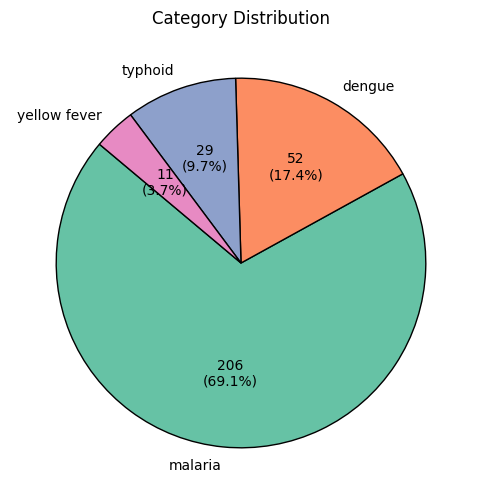

In [54]:
# Define a helper function for autopct to show count and percentage
def autopct_format(percent):
    total = distribution.sum()
    count = int(round(percent * total / 100.0))
    return f"{count}\n({percent:.1f}%)"

# Create the pie chart
def get_pie_chart_distribution(distribution, title='Category Distribution'):
    colors = sns.color_palette("Set2", len(distribution))  # Using Seaborn's "Set2" palette
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pie(
        distribution,
        labels=distribution.index,
        autopct=autopct_format,
        colors=colors,
        startangle=140,
        wedgeprops={'edgecolor': 'black'}
    )

    ax.set_title(title)
    plt.show()

# Plot the pie chart
distribution = data['diagnosed_diseases'].value_counts()
get_pie_chart_distribution(distribution)

There are very few cases of yellow fever and typhoid, which will impact performance further ahead. We could target this issue in a few ways:
* Upsample minority classes (most recommended, will do this prior to train)
* Join minority classes (loss of utility)
* Downsample majority classes (least recommended, dataset is already small)

### <a id='toc1_4_2_'></a>[Encode target labels](#toc0_)

In [55]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["diagnosed_diseases"])

In [56]:
data[["Target", "diagnosed_diseases"]].value_counts()

Target  diagnosed_diseases
1       malaria               206
0       dengue                 52
2       typhoid                29
3       yellow fever           11
Name: count, dtype: int64

We will save this mapping before dropping the disease column so we can keep track of results.

In [57]:
# Save mapping between Target and diagnosed_diseases
target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(target_mapping)

{'dengue': np.int64(0), 'malaria': np.int64(1), 'typhoid': np.int64(2), 'yellow fever': np.int64(3)}


### <a id='toc1_4_3_'></a>[Drop all features that can cause a target leak](#toc0_)

This is done to simulate a real environment, were the diagnose would still be unknown.

In [58]:
data.shape

(298, 108)

In [59]:
data = data.drop(columns=["diagnosed_diseases",
                        "other_diagnosed_diseases",
                        "Dengue (Dengua)",
                        "Maladies diagnostiquées",  
                        'Dengue dans le menage (Household Dengue)',
                        'Maladies diagnostiquées/Paludisme (Malaria)',
                        'Maladies diagnostiquées/Dengue',
                        'Maladies diagnostiquées/Fièvre jaune (yellow fever)',
                        'Maladies diagnostiquées/Fièvre Typhoïde (Thyphoid fever)',
                        'Maladies diagnostiquées/Autres maladies diagnostiqué (Others diseases)',
                        'Autres maladies présentées par le patient',
                        "Test TDR"])

In [60]:
data.shape

(298, 96)

### <a id='toc1_4_4_'></a>[Encode remaining categorical variables](#toc0_)

In [61]:
data.select_dtypes(include=['object']).columns

Index(['Centre de santé', 'Genre (Gender)', 'Type de fièvre (Type of Fever)'], dtype='object')

In [62]:
# Convert categorical variable into dummy/indicator variables.
data_encoded = pd.get_dummies(data.drop(columns=["Target"])) # note: setting dummy_na to True to handle missing values by creating a new category could be an option

### <a id='toc1_4_5_'></a>[Stratified train/val/test split](#toc0_)

In [63]:
# Train/test split 70/30 (stratify based on target)
X_train, X_test, y_train, y_test = train_test_split(data_encoded, data["Target"], test_size=0.3, random_state=42, stratify=data["Target"])

In [64]:
# Save feature names
feature_names=data_encoded.columns

#### <a id='toc1_4_5_1_'></a>[Standardize Numerical Features](#toc0_)

In [65]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### <a id='toc1_4_5_2_'></a>[Upsample minority classes](#toc0_)

This was arguably one of the most important steps to improve results in the end. Here are a few important reasons showing **why resampling is used for upsampling minority classes** to keep in mind:

**Balance the Dataset:** Many machine learning models perform better when classes are balanced. Upsampling helps avoid bias toward the majority class.

**Keep the Original Data Distribution (Sort Of):** While upsampling duplicates data points, it retains the overall characteristics of the minority class.

In [66]:
# Initialize SMOTE for a multiclass problem
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("New class distribution after SMOTE:", np.bincount(y_train_smote))

New class distribution after SMOTE: [144 144 144 144]


In [67]:
""" # Upsample only the classes that are underrepresented (minority classes)
max_count = distribution.max()
upsampled_dfs = []
for cls, count in distribution.items():
    df_cls = data[data['diagnosed_diseases'] == cls]
    if count < max_count:
        df_cls_upsampled = resample(
            df_cls,
            replace=True,       # sample with replacement
            n_samples=max_count,
            random_state=42     # reproducibility
        )
        upsampled_dfs.append(df_cls_upsampled)
    else:
        upsampled_dfs.append(df_cls)

# Combine the upsampled minority classes with the majority classes
data_balanced = pd.concat(upsampled_dfs)

# Optionally, shuffle the new DataFrame
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new balanced class distribution
title="New class distribution after upsampling minority classes"
new_distribution = data_balanced['diagnosed_diseases'].value_counts()
get_pie_chart_distribution(new_distribution, title=title) """

' # Upsample only the classes that are underrepresented (minority classes)\nmax_count = distribution.max()\nupsampled_dfs = []\nfor cls, count in distribution.items():\n    df_cls = data[data[\'diagnosed_diseases\'] == cls]\n    if count < max_count:\n        df_cls_upsampled = resample(\n            df_cls,\n            replace=True,       # sample with replacement\n            n_samples=max_count,\n            random_state=42     # reproducibility\n        )\n        upsampled_dfs.append(df_cls_upsampled)\n    else:\n        upsampled_dfs.append(df_cls)\n\n# Combine the upsampled minority classes with the majority classes\ndata_balanced = pd.concat(upsampled_dfs)\n\n# Optionally, shuffle the new DataFrame\ndata_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)\n\n# Verify the new balanced class distribution\ntitle="New class distribution after upsampling minority classes"\nnew_distribution = data_balanced[\'diagnosed_diseases\'].value_counts()\nget_pie_c

### <a id='toc1_4_6_'></a>[Run Experiment - KNN, SVC and Ensemble](#toc0_)

#### <a id='toc1_4_6_1_'></a>[Training and Evaluation](#toc0_)

Considering that the main goal of this model is to predict diseases in a population, it is imperative to **avoid False Negatives (FP)**. Therefore, **Recall (sensitivity)** is particularly important.

I chose to train and compare 3 models based on https://scikit-learn.org/stable/machine_learning_map.html

In [68]:
def print_evaluation_results(name, scores, accuracy, precision, recall, f1, cm):
    print(f"\n{name} Results")
    print("-" * 50)
    print(f"Cross-validation accuracy scores: {scores}")
    print(f"Mean accuracy: {np.mean(scores):.4f}")
    print(f"Test set accuracy: {accuracy:.4f}\n")
    
    metrics_df = pd.DataFrame({
        "Metric": ["Precision (macro avg)", "Recall (macro avg)", "F1 Score (macro avg)"],
        "Score": [precision, recall, f1]
    })
    display(metrics_df)
    
    print("Confusion Matrix:")
    display(pd.DataFrame(cm, index=["Actual " + str(i) for i in range(cm.shape[0])],
                             columns=["Predicted " + str(i) for i in range(cm.shape[1])]))

I'll also perform cross validation to ensure robustness.

In [69]:
# Define classifiers
svc = SVC(kernel='linear', random_state=42, probability=True)
knn = KNeighborsClassifier(n_neighbors=5)
ensemble = VotingClassifier(estimators=[('svc', svc), ('knn', knn)], voting='soft')

# List of models to evaluate
models = {'SVC': svc, 'KNN': knn, 'Ensemble': ensemble}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model
for name, model in models.items():
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    print_evaluation_results(name, scores, accuracy, precision, recall, f1, cm)



SVC Results
--------------------------------------------------
Cross-validation accuracy scores: [0.93965517 0.93043478 0.93043478 0.93043478 0.85217391]
Mean accuracy: 0.9166
Test set accuracy: 0.6889



,Metric,Score
0,Precision (macro avg),0.502918
1,Recall (macro avg),0.525650
2,F1 Score (macro avg),0.508433


Confusion Matrix:


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,6,7,2,1
Actual 1,8,52,2,0
Actual 2,2,4,2,1
Actual 3,1,0,0,2



KNN Results
--------------------------------------------------
Cross-validation accuracy scores: [0.82758621 0.86086957 0.86086957 0.80869565 0.82608696]
Mean accuracy: 0.8368
Test set accuracy: 0.5111



,Metric,Score
0,Precision (macro avg),0.395573
1,Recall (macro avg),0.520217
2,F1 Score (macro avg),0.396900


Confusion Matrix:


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,7,4,4,1
Actual 1,11,33,7,11
Actual 2,4,1,4,0
Actual 3,1,0,0,2



Ensemble Results
--------------------------------------------------
Cross-validation accuracy scores: [0.92241379 0.91304348 0.90434783 0.94782609 0.88695652]
Mean accuracy: 0.9149
Test set accuracy: 0.6333



,Metric,Score
0,Precision (macro avg),0.431713
1,Recall (macro avg),0.529234
2,F1 Score (macro avg),0.454364


Confusion Matrix:


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,6,6,3,1
Actual 1,6,46,6,4
Actual 2,3,2,3,1
Actual 3,1,0,0,2


From these, SVC seems to be the best option. Focusing on these:

![Figure 1. SVC classification report](../figures/SVC_report_final.png)

Note the test accuracy of 92%, a promising result. The macro averages of F1-score 50% and recall 53%, although not very exciting, could yet be improved through further hyperparameter tuning/optimization. Furthermore, the lack of samples for diseases other than Malaria impacts learning and evaluating these. 

Let's also bring attention to the `target_mapping` again for analysis:

In [70]:
target_mapping

{'dengue': np.int64(0),
 'malaria': np.int64(1),
 'typhoid': np.int64(2),
 'yellow fever': np.int64(3)}

Looking at the confusion matrix, it seems that the few missclassifications that occurred were more pronounced in Malaria, which makes sense as it was the majority class originally, with a wider distribution of variables. 

It's also worth mentioning that the least represent class - typhoid and yellow fever - were practically perfectly identified, which could be a bi-product of upsampling. To get a more representative distribution, more samples would be needed for these specific cases, to ensure the reliability of these results in new scenarios. 

Co-occurring diseases in the same patient may also lead to misslabeling, which should be addressed in a future implementation - maybe by selecting a priority of detection, or adding multiple disease identifications as an option for modelling.

#### <a id='toc1_4_6_2_'></a>[Feature Importance (Permutation Importance)](#toc0_)

In [71]:
# Compute permutation importance
final_model = models['SVC']
perm_importance = permutation_importance(final_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

features = np.array(feature_names)

# Sort features by importance
sorted_idx = np.argsort(np.abs(perm_importance.importances_mean))[::-1] # Descening order of absolute values


Top 10 Most Important Features (Permutation Importance):
1. Âge (Age): 0.052222
2. Pression artérielle (moyenne mmHg ± SD): 0.042222
3. Douleur musculaire ( Muscle pain): 0.040000
4. Arterial blood pressure (mean mmHg ± SD): 0.040000
5. Vertige (Dizzy): 0.038889
6. Fièvre depuis 48 heures(Fever 48 hrs): 0.037778
7. Somnolence ou léthargie  (Drowsiness or lethargy): 0.036667
8. Douleur articulaire (Joint pain): 0.033333
9. Genre (Gender)_femme: 0.031111
10. Nombre de globules blancs (cellules/ML) / White blood cell count / WBC count (cells/ML): 0.031111


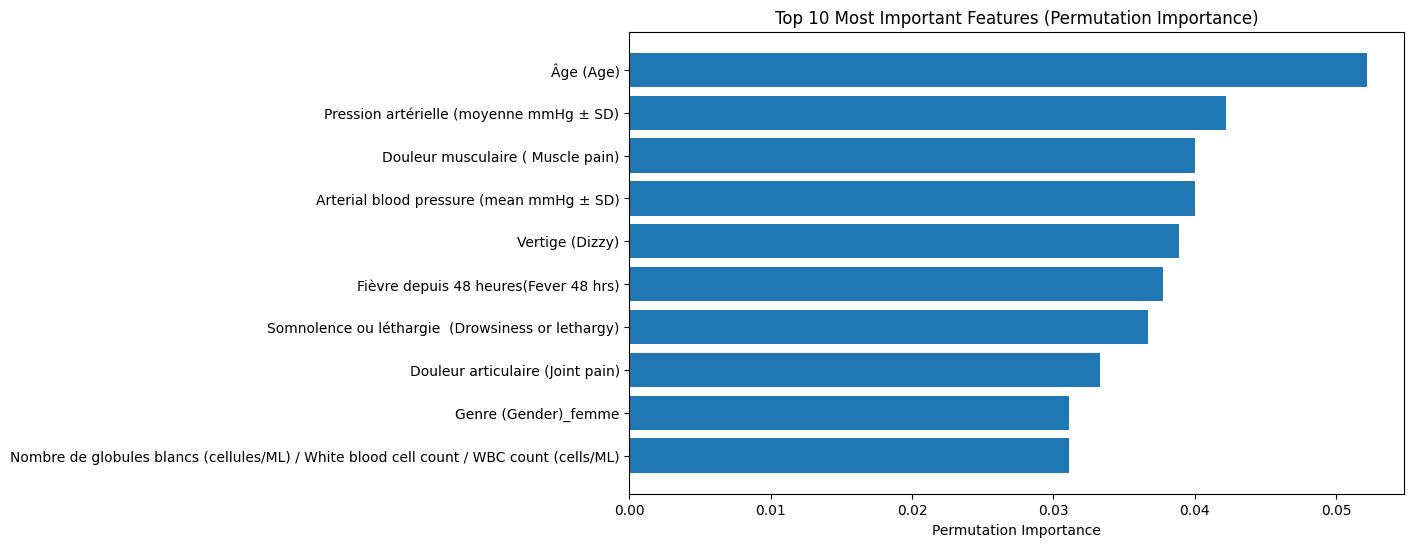

In [72]:
# Select top N features
top_n = 10
top_n_features = features[sorted_idx][:top_n]
top_n_importance = perm_importance.importances_mean[sorted_idx][:top_n]

# Print top 10 feature names and their importance scores
print(f"Top {top_n} Most Important Features (Permutation Importance):")
for i, (feature, importance) in enumerate(zip(top_n_features, top_n_importance), 1):
    print(f"{i}. {feature}: {importance:.6f}")

# Plot top 10 features
plt.figure(figsize=(top_n, 6))
plt.barh(top_n_features[::-1], top_n_importance[::-1])  # Reverse order for a better visual
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_n} Most Important Features (Permutation Importance)")
plt.show()

It seems that the most relevant features include age and a few symptoms, such as blood pressure, muscle pain, dizziness, and fever.

#### <a id='toc1_4_6_3_'></a>[Save the final model](#toc0_)

In [73]:
# Ensure the 'model' directory exists
if not os.path.exists(os.path.join(base_dir, "model")):
    os.makedirs(os.path.join(base_dir, "model"))

# Save the model using joblib
joblib.dump(final_model, os.path.join(base_dir, "model", "svc.pkl"))

print("Model saved successfully in the 'model' directory!")

Model saved successfully in the 'model' directory!


## <a id='toc1_5_'></a>[Conclusion](#toc0_)

The use case I chose allowed me to experiment within a familiar Biomedical Field, while showcasing the data science skills that were the target of this exercise. The results achieved with the SVC model were promising, with a test accuracy of 92%, even without further optimization.

The dataset had a few issues, mainly the class umbalance between Malaria (majority) and the remaining. Also all patients in the dataset were ill, so there was no control group to compare to. My solution also has the limitation of co-occurring diseases not showing in the target, which could be fixed by having a model for each disease - which I chose not to do to keep the solution leaner and easy to follow. 

I would also need to allocate some extra time to refactor and organize the code into scripts and pipelines, modularizing the code where needed, to facilitate reusage and deployment.

### <a id='toc1_5_1_'></a>[Next Steps - Deployment & Monitoring Considerations](#toc0_)

Finally, I envision this model being used in an hypothetical hospital setting as a tool to assist in diagnosis. Patient parameters can be introduced from clinical records to detect early signs of specific infectious diseases and automatically trigger an alarm for clinical appointment, preventing further spread of disease.

As mentioned during the report, the recall is an important metric to keep track of, as it may imply that the model does not detect every suspicious case. It should still be balanced with precision, to prevent excessibe alarms. Moving further, it should be ensured that predictions align with the annotated data through continuous monitoring of these metrics.